#### 7

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(1,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)

var_countries  <-  dim(read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
this_file_models_list  <-  list()
this_model_list  <-  list()



In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

        allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }
this_file_models_list[[1]]  <-  this_model_list




[1]   1  84  85 108
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120
[1]  25 108 109 132
|[1]  37 120 121 144
|[1]  49 132 133 156


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12612.7352  -8133.8118 -11038.8736  -6227.5303  -1121.9789   8743.6536
 [7]  12922.1961    806.7579   -560.7183  -5539.6640 -10472.9525 -25921.5106
[13] -12432.8990  -7271.2115  -9316.9162  -7635.7955  -2287.6819   5497.1159
[19]   6898.8047  -1116.6434  -1597.0651  -6692.0156  -8371.4297 -20858.8124

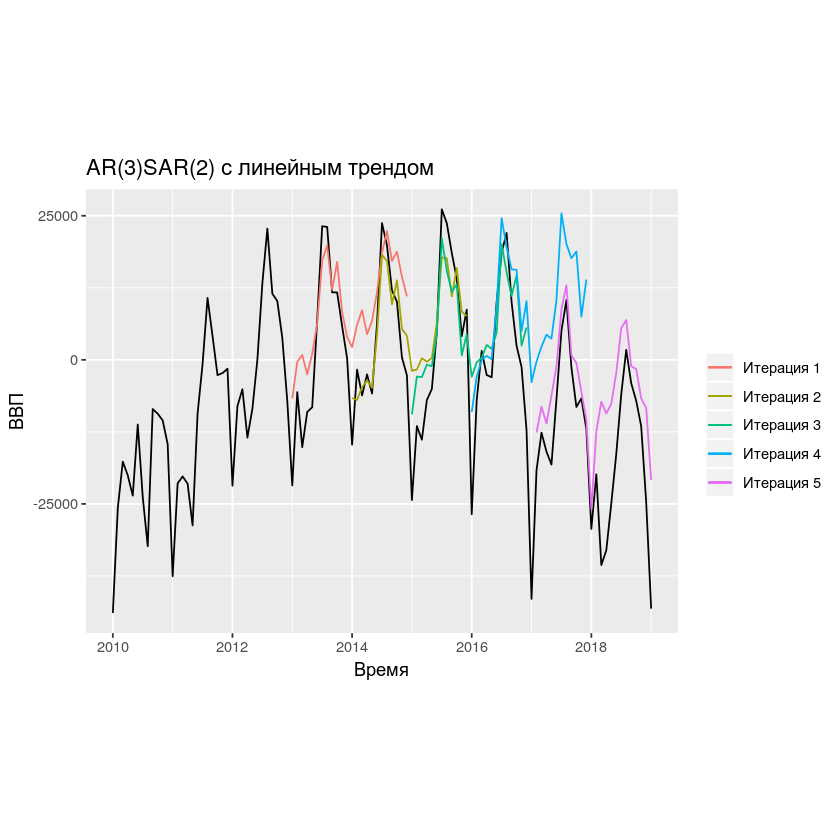

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-6560.987,9250.423,302.23551,1
-2088.177,7332.513,112.02172,13
-3283.564,8805.191,95.35033,25
-13501.390,16826.182,220.29663,37
-8967.220,11664.700,74.52024,50


In [15]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-6880.2675 10775.8018   160.8849    25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc_noweights.rds")


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,13590.31
2 level (type),65.94486,290.9240,12888.11
2 level (clusetered),95.70981,194.1196,13401.44


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-6560.987,9250.423,302.23551,1
-2088.177,7332.513,112.02172,13
-3283.564,8805.191,95.35033,25
-13501.390,16826.182,220.29663,37
-8967.220,11664.700,74.52024,50


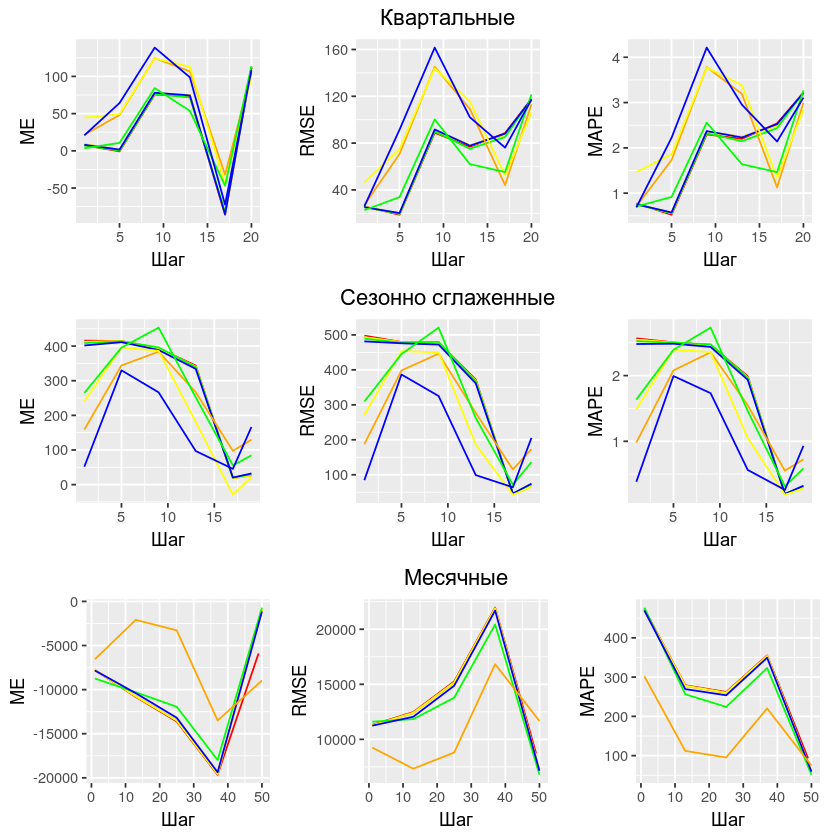

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all_noweights.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)

    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         

    
    
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[2]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-6062.646,8421.202,342.44004,1
-6132.201,8563.879,182.92506,13
-5834.993,9379.027,134.40299,25
-14062.908,16768.614,245.41031,37
-7389.034,9616.080,90.59819,50


In [27]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15101.1738 -10901.1593 -10424.4858 -10344.3793   -294.9450  11163.0003
 [7]  12572.2982   4878.9525   -143.3179  -5012.3126  -9453.0376 -33993.6718
[13] -16076.0096 -11691.7772 -11809.4549 -12190.6855  -3184.7726   6975.7847
[19]   8589.8025   1486.0240  -2966.2267  -7899.4554 -11903.6790 -34493.4940

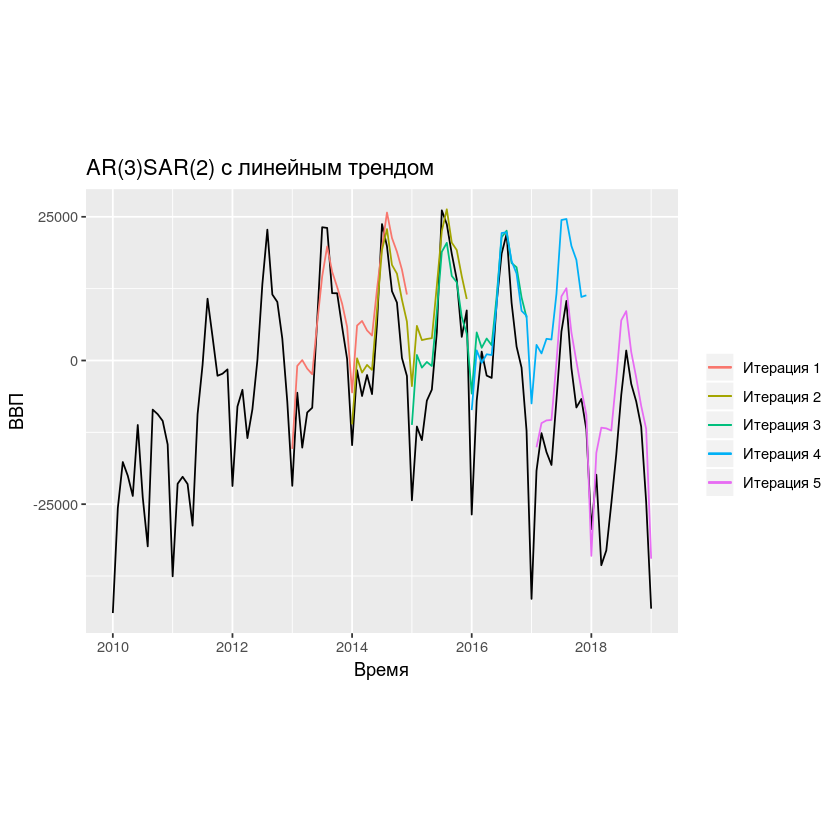

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7896.3565 10549.7603   199.1553    25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,10549.76
2 level (type),65.94486,290.9240,12888.11
2 level (clusetered),95.70981,194.1196,13401.44


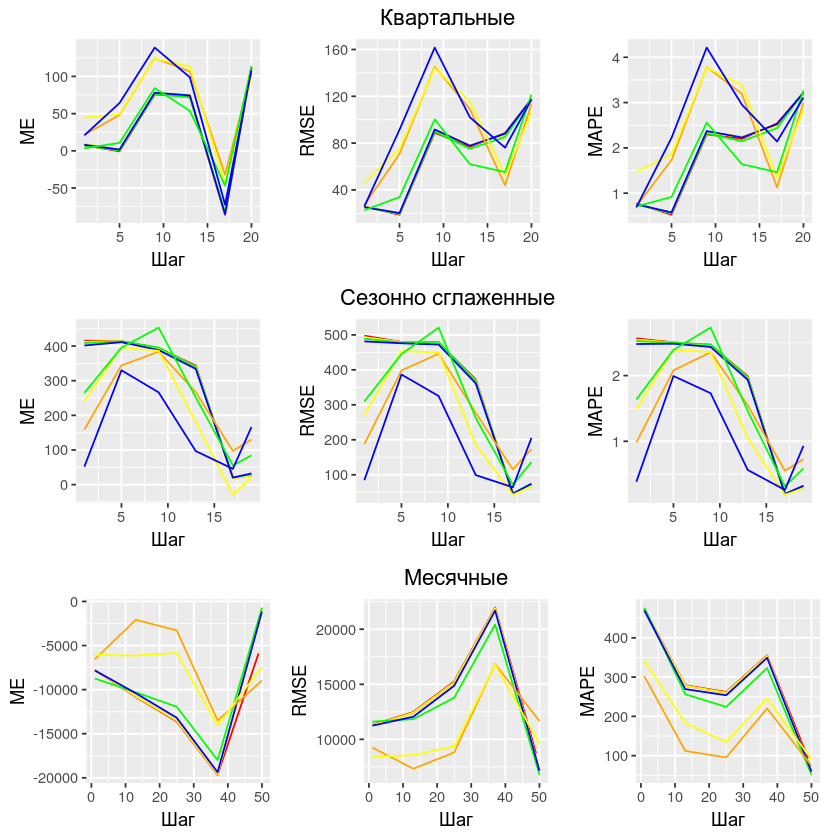

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         

     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[3]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-12594.182728,15193.852,494.88681,1
-8204.649008,11047.159,168.17886,13
-5292.848966,10401.736,118.82631,25
-11347.715536,14938.389,217.23244,37
-1.708651,7173.193,79.36989,50


In [40]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14156.8030 -19008.9846 -14220.4625 -10489.0567 -12918.6723  12665.7040
 [7]   7413.7059  -6114.9575    354.3583 -14787.0017 -18481.1604 -38368.6705
[13] -25038.3132 -23280.4821 -19954.1047 -20626.1549 -18093.5502   4268.4913
[19]  -1581.1450 -12733.5327  -7884.7328 -23478.0444 -22252.0186 -40748.4042

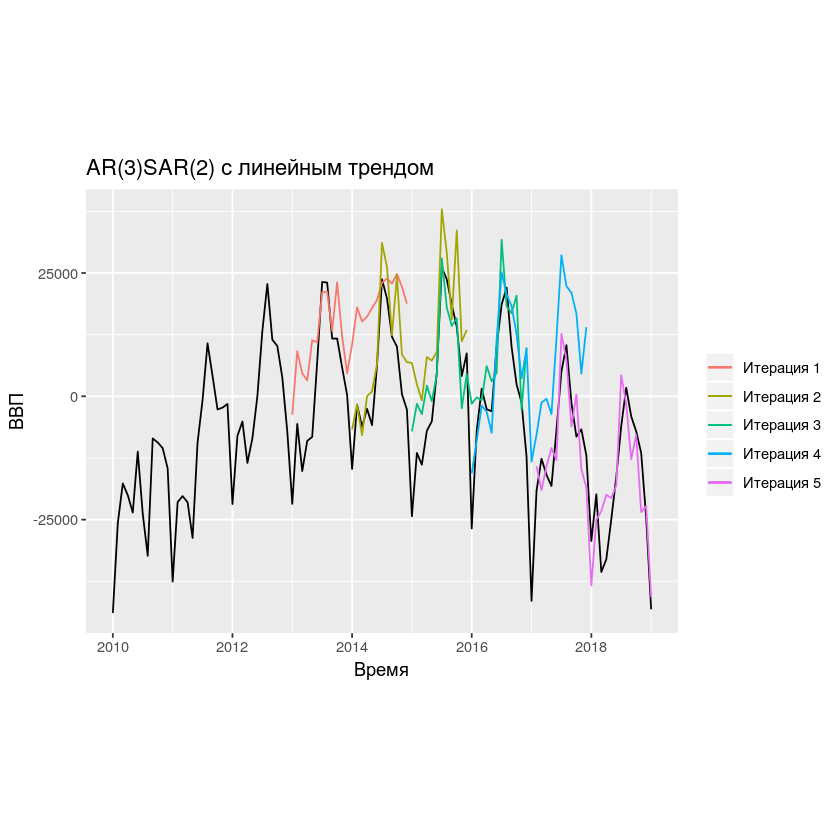

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-7488.2210 11750.8660   215.6989    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,10549.76
2 level (type),65.94486,290.9240,12888.11
2 level (clusetered),95.70981,194.1196,13401.44


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,10549.76
2 level (type),65.94486,290.9240,11750.87
2 level (clusetered),95.70981,194.1196,13401.44


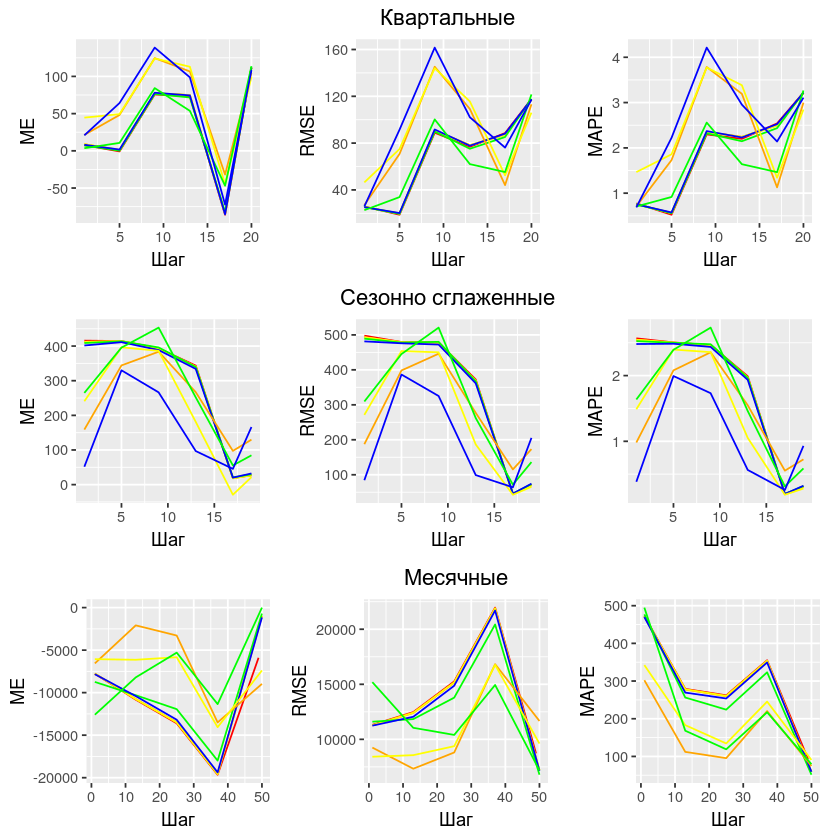

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[4]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-9129.853,11237.258,396.04280,1
151.690,6223.458,96.10605,13
-2752.383,8144.599,88.02620,25
-12477.624,15585.793,219.32575,37
-8153.609,10411.980,85.50777,50


In [54]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13281.0044 -10079.7229 -10046.6288  -5748.3204   -146.8555  12116.3181
 [7]  15325.0228   2201.3607    983.5147  -5441.2367 -12106.3719 -31242.7571
[13] -14713.8392 -11431.8300 -11606.5597  -9092.2634  -3879.1912   7273.8034
[19]   9418.2779  -1535.3163  -2254.7021  -8851.7492 -12117.6712 -27610.6706

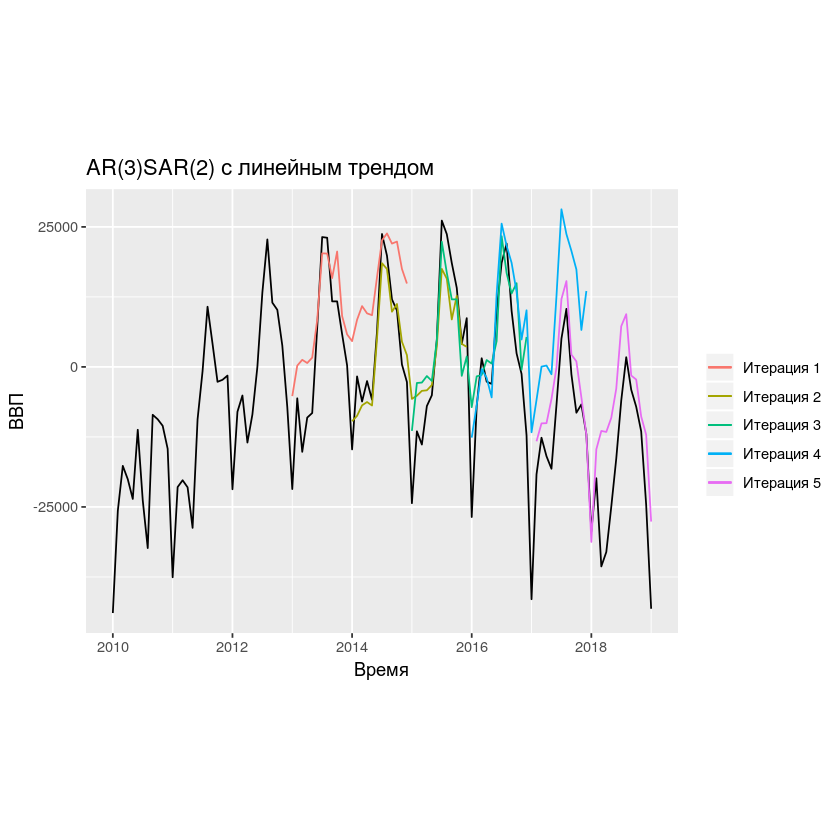

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-6472.3556 10320.6177   177.0017    25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,10549.76
2 level (type),65.94486,290.9240,11750.87
2 level (clusetered),95.70981,194.1196,13401.44


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,266.2395,10775.80
2 level (state),89.90578,245.0236,10549.76
2 level (type),65.94486,290.9240,11750.87
2 level (clusetered),95.70981,194.1196,10320.62


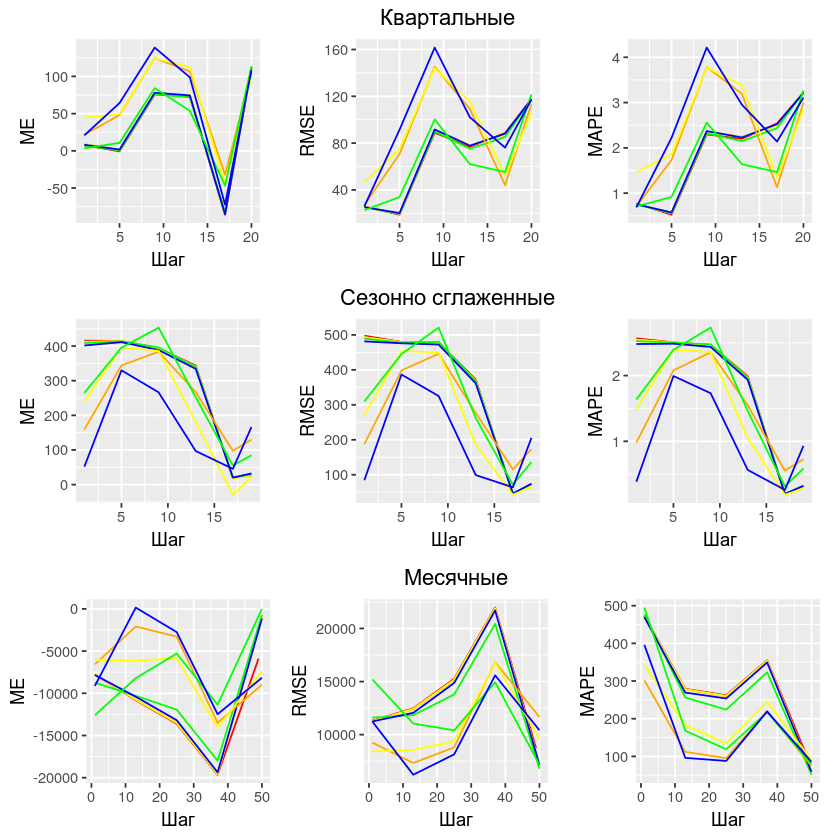

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:

saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")


In [62]:
all_models_list <- readRDS("all_models_list.rds")
all_models_list[[3]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")




